# Keywords Extraction from Emails via Entropy Based Methods

## Motivation for Keywords/Key-phrases extraction within emails:
- Email traffic is really high and it would be helpful to get a general idea of what the email is about without going through it.
- Key phrases can offer an easy form of summarization - they convey the main information within the email.
- Key phrases and keywords can be used later on to filter emails into categories or for retrieval of similar emails based on keywords.

### Note:
The quality of the results during the workshop are incremental i.e. - they will improve as it progresses.

## Existing methods for keywords extraction
- RAKE: partitions documents by stop-words and word/phrase delimiters into candidate keywords. 
Then computes co-occurrence matrix and based on the matrix gives a score for each word(deg/freq) - the it selects top n scores of summed sequences.
Overall efficient and light. 
https://www.researchgate.net/publication/227988510_Automatic_Keyword_Extraction_from_Individual_Documents

- YAKE!: 
A light-weight unsupervised automatic keyword extraction method which rests on text statistical features extracted from single documents to select the most important keywords of a text.

- TF-IDF - self-explanatory.

- Key-Bert computes sentence embedding and then finds ngrams which has the highest cosine similarity to the sentence embedding.

- Key-Bert with POS pre matching - same, but instead od specifying ngrams you specify POS matchers for phrases.

# AESLC -  Annotated Enron Subject Line Corpus

In [1]:
import torch
import numpy as np
!python -m spacy download en_core_web_sm
%pip install datasets
import spacy
nlp = spacy.load("en_core_web_sm")


/bin/sh: python: command not found
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.5/139.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing install

In [2]:
from datasets import load_dataset_builder
ds_builder = load_dataset_builder("aeslc")

ds_builder.info.description

ds_builder.info.features

{'email_body': Value(dtype='string', id=None),
 'subject_line': Value(dtype='string', id=None)}

In [3]:
from datasets import load_dataset

dataset = load_dataset("aeslc")

Computing checksums:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/14436 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1960 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1906 [00:00<?, ? examples/s]

Dataset aeslc downloaded and prepared to /Users/kipnisal/.cache/huggingface/datasets/aeslc/default/1.0.0/eb8e30234cf984a58ebe9f205674597ac1db2ec91e7321cd7f36864f7e3671b8. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## Example for keywords from email

In [73]:
# Select a random  sample from the training set
import random
# for i in random.sample(range(0, len(dataset["train"])), 3):
#     print(dataset["train"][i]["email_body"])

print(dataset["train"][0]["email_body"])
print("Possible Keywords:")
print(dataset["train"][0]["subject_line"])

Greg/Phillip,  Attached is the Grande Communications Service Agreement.
The business points can be found in Exhibit C.  I Can get the Non-Disturbance agreement after it has been executed by you and Grande.
I will fill in the Legal description of the property one I have received it.
Please execute and send to:  Grande Communications, 401 Carlson Circle, San Marcos Texas, 78666 Attention Hunter Williams.
<<Bishopscontract.doc>>

Possible Keywords:
Service Agreement


## GPT2

- Trained on WebText Dataset: filtered outbound links from reddit which received at least 3 karma( heuristic indicator for whether other users found the link interesting, educational,or just funny).
- 355M parameters, similar largest original BERT (GPT-3 in comparison 175 BN parameters)
- Byte Pair encoding tokenizer (vocab size of 50257) - https://towardsdatascience.com/comparing-transformer-tokenizers-686307856955
- Trained on 512 batch size
- Input size 1024 tokens
- Similar to original GPT and any decoder Transformer in architecture.
- Can be used to evaluate entropy since it's auto-regressive - attends to past (similar to information flow)  

In [ ]:
%pip install transformers

- Model Card: https://huggingface.co/gpt2-medium
- Paper: https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf

In [9]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel

# This tokenizer has been trained to treat spaces like parts of the tokens (a bit like sentencepiece) so a word will
# be encoded differently whether it is at the beginning of the sentence (without space) or not
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2-medium')

# 355M parameter version of GPT-2 which was trained with language modeling objective
# Has a language modeling head on top
model = GPT2LMHeadModel.from_pretrained('gpt2-medium')

## Perplexity of auto-regressive LLMs:

- GPT2 has been trained with minimization of cross entropy loss on next token prediction(which is the as same max likelihood)
- This can be viewed as training on minimizing the perplexity/cross entropy - i.e. predicting the next most probable token /encoding the language in the most efficient manner
- Perplexity score(base 2) - confusion of the model, e.g perplexity 10 means that the model is confident in the word as if it had to choose it uniformly from 10 words

## Average word entropy per email based on email length

In [10]:
def normalize_body(email_body, tokenizer, is_batched=False):
    if is_batched:
        email_body = [normalize_body(email, tokenizer, is_batched=False) for email in email_body]
    else:
        email_body = email_body.replace("\t", " ")
        # Adding bos token to the beginning of each email
        email_body = tokenizer.bos_token + " ".join(email_body.split())

    return email_body


def tokenize_emails(dataset, tokenizer, should_use_padding=True, should_only_normalize=False):
    dataset = dataset.map(
        lambda batch: {
            "email_body": normalize_body(batch["email_body"], tokenizer, is_batched=True)
        },
        batched=True,
    )
    if should_only_normalize:
        return dataset
    dataset.set_format(type="torch")
    # Set a padding token
    tokenizer.pad_token = tokenizer.eos_token
    # Batch tokenize the dataset
    tokenized_emails = dataset.map(
        lambda x: {
            **tokenizer(
                x["email_body"],
                return_tensors="pt",
                truncation=True,
                padding="max_length" if should_use_padding else False,
                add_special_tokens=True,
            )
        }
    )

    # set format of the dataset to pytorch tensors

    return tokenized_emails


In [11]:
tokenized_emails_non_padded = tokenize_emails(dataset["train"], tokenizer, should_use_padding=False)

Loading cached processed dataset at C:\Users\tsale\.cache\huggingface\datasets\aeslc\default\1.0.0\eb8e30234cf984a58ebe9f205674597ac1db2ec91e7321cd7f36864f7e3671b8\cache-29fe0f440707d9ac.arrow
Loading cached processed dataset at C:\Users\tsale\.cache\huggingface\datasets\aeslc\default\1.0.0\eb8e30234cf984a58ebe9f205674597ac1db2ec91e7321cd7f36864f7e3671b8\cache-2c8a3fbb292a3fcb.arrow


In [12]:
# Compute percentiles of tokenized emails
import numpy as np

length_dataset = tokenized_emails_non_padded.map(lambda x: {"len" :len(x["input_ids"][0])})
# tokenized_emails_lengths = [len(tokenized_emails_non_padded["input_ids"][0]) for tokenized_email in tokenized_emails_non_padded]
print(" 95th percentile of token length of tokenized emails: ")
# print(np.percentile(tokenized_emails_lengths, 95))
print(np.percentile(length_dataset["len"], 95))
# Average length of tokenized emails
print("Median of tokenized emails: ")
# print(np.mean(tokenized_emails_lengths))
print(np.percentile(length_dataset["len"], 50))


Loading cached processed dataset at C:\Users\tsale\.cache\huggingface\datasets\aeslc\default\1.0.0\eb8e30234cf984a58ebe9f205674597ac1db2ec91e7321cd7f36864f7e3671b8\cache-f7d252dd4dcd1df9.arrow


 95th percentile of token length of tokenized emails: 
451.0
Median of tokenized emails: 
96.5


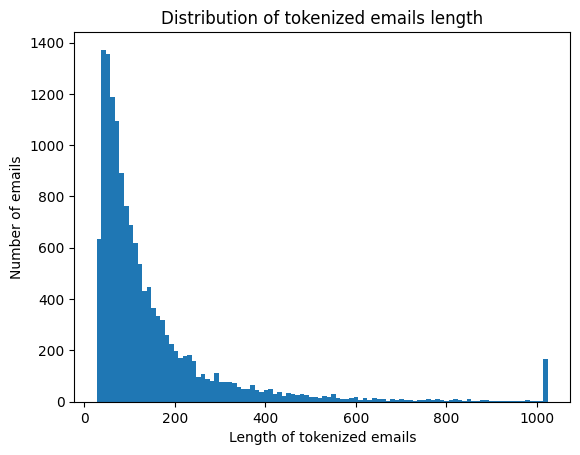

In [8]:
# Plot distribution of tokenized emails length
import matplotlib.pyplot as plt


def plot_distribution(dataset, title):
    plt.hist(dataset["len"], bins=100)
    plt.title(title)
    # Set y axis label
    plt.ylabel("Number of emails")
    # Set x axis label
    plt.xlabel("Length of tokenized emails")
    plt.show()


plot_distribution(length_dataset, "Distribution of tokenized emails length")

In [13]:
padded_train = tokenize_emails(dataset["train"], tokenizer, should_only_normalize=False, should_use_padding=True)


Loading cached processed dataset at C:\Users\tsale\.cache\huggingface\datasets\aeslc\default\1.0.0\eb8e30234cf984a58ebe9f205674597ac1db2ec91e7321cd7f36864f7e3671b8\cache-659ab0a602d2b399.arrow
Loading cached processed dataset at C:\Users\tsale\.cache\huggingface\datasets\aeslc\default\1.0.0\eb8e30234cf984a58ebe9f205674597ac1db2ec91e7321cd7f36864f7e3671b8\cache-0746aca2abf48bb0.arrow


- It seems that average entropy per token is going down as emails are longer
- Context of longer emails gives the model more confidence on predictions.
- Larger emails contain more redundancy and can be encoded more efficiently on average.

In [15]:
def calculate_entropy_from_logits(logits , relevant_tokens ):
    probs = logits[0].softmax(dim=-1)

    # Get the actual probs of each token
    actual_probs = probs[range(len(probs) -1), relevant_tokens]

    # Get cross entropy of each token
    entropy = -actual_probs.log2()
    return entropy

In [17]:
def get_tokens_entropy(model, tokenized_email):

    # Convert model to cpu
    model.cpu()
    # Get probabilities from logits
    logits = model(**tokenized_email).logits

    # Remove bos token from tokenized email
    relevant_tokens = tokenized_email["input_ids"][0][1:]

    entropy = calculate_entropy_from_logits(logits, relevant_tokens)

    return entropy , relevant_tokens, logits

In [18]:
def sample_email():
    email = dataset["train"][random.randint(0, len(dataset["train"]))]
    email_body = email["email_body"]
    email_body = email_body.replace("\t", " ")
    email_body = " ".join(email_body.split())
    return email_body


In [19]:
def tokenize_single_email(email_body, tokenizer):
    tokenized_email = tokenizer(
        tokenizer.bos_token + email_body,
        return_tensors="pt",
        truncation=True,
        add_special_tokens=True,
    )
    return tokenized_email

In [20]:
def get_top_n_entropy_tokens(entropy, relevant_tokens, n):
    # Select the n tokens with the highest entropy
    top_n_elements = entropy.topk(n, dim=-1).indices

    # Take first n elements
    top_n_elements = top_n_elements[:n]

    # Select these tokens from the original tokenized email
    top_n_tokens = relevant_tokens[top_n_elements]

    return top_n_tokens


In [21]:
def decode_and_print_tokens_with_entropy(relevant_tokens, entropy, should_display_entropy=True):
    decoded = tokenizer.batch_decode(relevant_tokens)

    if should_display_entropy:
        token_entropy = list(zip(decoded, entropy.tolist(), range(len(relevant_tokens))))
    else :
        token_entropy = list(zip(decoded, range(len(relevant_tokens))))

    print(token_entropy)

In [22]:
def get_top_k_indices(some_list, k):
    # Convert to numpy array
    some_list = np.array(some_list)
    # Get the indices of the top k values
    top_k_indices = some_list.argsort()[-k:][::-1]
    # return as list
    return top_k_indices.tolist()

In [23]:
def get_k_pairs_of_highest_entropy(entropy, decoded, k, n):
    entropy_pairs = []
    entropy_pairs_tokens = []
    # Fill tensor with average entropy of each k pair
    for i in range(len(entropy) - n):
        entropy_pairs.append(entropy[i:i+n].mean().detach().numpy())
        entropy_pairs_tokens.append(decoded[i:i+n])

    # Choose the n pairs with the highest average entropy
    top_n_pairs = get_top_k_indices(entropy_pairs, k)

    # Get original 
    top_n_pairs_tokens = [entropy_pairs_tokens[i] for i in top_n_pairs]

    return top_n_pairs_tokens

## Get keywords directly from Email By Cross-Entropy(log loss)
- Tokenize email
- Calculate cross entropy of each token(which is an upper bound to the real entropy)
- Select the n words with the highest entropy

In [24]:
email_body =sample_email()
print(email_body)

I spoke to Kate Cole and she said Enron NetWorks (I'm not sure of the correct spelling yet) was incorporated as a Delaware corporation on 4/13/00. She has made me a copy of their articles of incorporation and LLC Agreement and I am sending a messenger to pick them up, as well as a copy of the officers and directors, which appears to have been approved. The banking resolution went to Julia today for signature. Do we need to adopt any other resolutions (brokerage, approval of agreements, etc.). How about adoption of the trading policy?


In [25]:
# Tokenize the email with  bos token at the beginning and eos token at the end
tokenized_email = tokenize_single_email(email_body, tokenizer)

num_of_tokens = len(tokenized_email["input_ids"][0])
print(f"Number of tokens in the email: {num_of_tokens}")


Number of tokens in the email: 117


### Log cross Entropy(log loss) of original email by model

In [26]:
should_display_entropy = True

entropy , relevant_tokens, logits = get_tokens_entropy(model, tokenized_email)

decode_and_print_tokens_with_entropy(relevant_tokens, entropy, should_display_entropy)


[('I', 5.774309158325195, 0), (' spoke', 10.583921432495117, 1), (' to', 1.4048041105270386, 2), (' Kate', 10.267398834228516, 3), (' Cole', 12.83829116821289, 4), (' and', 5.220125675201416, 5), (' she', 5.7715630531311035, 6), (' said', 3.98419451713562, 7), (' En', 16.947742462158203, 8), ('ron', 4.708259582519531, 9), (' Net', 18.046255111694336, 10), ('Works', 10.68776798248291, 11), (' (', 5.969388484954834, 12), ('I', 9.096165657043457, 13), ("'m", 3.6776819229125977, 14), (' not', 2.0491461753845215, 15), (' sure', 1.1812381744384766, 16), (' of', 5.57489013671875, 17), (' the', 0.5626698136329651, 18), (' correct', 4.9640960693359375, 19), (' spelling', 1.1721925735473633, 20), (' yet', 7.790988445281982, 21), (')', 0.6072407960891724, 22), (' was', 1.554545521736145, 23), (' incorporated', 10.50373363494873, 24), (' as', 4.5574164390563965, 25), (' a', 1.1972997188568115, 26), (' Delaware', 6.993647575378418, 27), (' corporation', 1.1859043836593628, 28), (' on', 3.9812917709

In [290]:
# Get argmax of the logits
argmax = logits.argmax(dim=-1)


# Decode these tokens
actual_tokens_decoded = tokenizer.batch_decode(argmax[0])

# Print the actual tokens
print(list(zip(actual_tokens_decoded, range(len(actual_tokens_decoded)))))

[('The', 0), (' enable', 1), (' the', 2), (' following', 3), (' PDF', 4), (' release', 5), ('.', 6), (' which', 7), (' includes', 8), (' will', 9), (' like', 10), (' to', 11), (' share', 12), (' to', 13), (' soon', 14), (' as', 15), (' possible', 16), ('.', 17), (' morning', 18), ('.', 19), ('\n', 20), (' note', 21), (' that', 22), (' you', 23), (' have', 24), (' received', 25), (' in', 26), (' fact', 27), (',', 28), (' received', 29), (' the', 30), (' the', 31), (' project', 32), ('1', 33), (' million', 34), (' deal', 35), (' $', 36), (' that', 37), (' us', 38), (' know', 39), (' if', 40), (' you', 41), (' have', 42), (' any', 43), (' questions', 44), (' questions', 45), ('.', 46), ('\n', 47), (' you', 48), ('.', 49), ('\n', 50)]


In [27]:
# print email body
print(email_body)

I spoke to Kate Cole and she said Enron NetWorks (I'm not sure of the correct spelling yet) was incorporated as a Delaware corporation on 4/13/00. She has made me a copy of their articles of incorporation and LLC Agreement and I am sending a messenger to pick them up, as well as a copy of the officers and directors, which appears to have been approved. The banking resolution went to Julia today for signature. Do we need to adopt any other resolutions (brokerage, approval of agreements, etc.). How about adoption of the trading policy?


In [28]:
# ngram length
n = 10
# number of pairs to print 
k = 1
decoded = tokenizer.batch_decode(relevant_tokens)
print("Pairs of tokens with the highest entropy:")
print(get_k_pairs_of_highest_entropy(entropy, decoded, k, n))

Pairs of tokens with the highest entropy:
[[' approved', '.', ' The', ' banking', ' resolution', ' went', ' to', ' Julia', ' today', ' for']]


## Extracting key-phrases with maximal entropy

In [29]:
# ngram length
n = 3
# number of pairs to print 
k = 3
decoded = tokenizer.batch_decode(relevant_tokens)
print("Pairs of tokens with the highest entropy:")
get_k_pairs_of_highest_entropy(entropy, decoded, k, n)

Pairs of tokens with the highest entropy:


[[' En', 'ron', ' Net'],
 [' Julia', ' today', ' for'],
 [' banking', ' resolution', ' went']]

## Use KeyBert to extract keywords
- document embeddings are extracted with BERT to get a document-level representation.  word embeddings are extracted for N-gram words/phrases.use cosine similarity to find the words/phrases that are the most similar to the document. The most similar words could then be identified as the words that best describe the entire document.

- Keybert github: https://github.com/MaartenGr/KeyBERT

In [ ]:
%pip install keybert

In [30]:
# Import keybert
from keybert import KeyBERT

kw_model = KeyBERT()
keywords = kw_model.extract_keywords(email_body, keyphrase_ngram_range=(1, 1), stop_words=None)
print(keywords)

[('enron', 0.4661), ('incorporation', 0.4312), ('incorporated', 0.3569), ('corporation', 0.3479), ('agreements', 0.345)]


In [31]:
keywords = kw_model.extract_keywords(email_body, keyphrase_ngram_range=(1, n), stop_words=None)
print(keywords)

[('delaware corporation on', 0.5408), ('enron networks not', 0.5218), ('as delaware corporation', 0.5194), ('resolutions brokerage approval', 0.503), ('enron networks', 0.5017)]


## Explanations for results:

 - Early token curse(most of the perplexity is assigned to the early tokens due to lack of context)
 - Distribution shift of email domain - higher perplexity score on email specific terms.
 

# Salient Sentences via average cross-entropy(log loss) of sentence

## Motivation
- Sentences with high cross-entropy(log loss) encode important information
- Focusing on such sentences can yield high quality keywords 

In [32]:
email_body =sample_email()
print(email_body)

I've located the Gas Nomination information that was prepared for Dec. 01 and updated to include Jan. 02 business. The Dec.01 numbers differ slightly from the initial numbers generated by James Centilli at TW as well as the numbers that Stephanie Miller conveyed in her Dec. 18th memo. These values are based on the nomination worksheets & actual power bills from he respective utilities. Thanks


In [ ]:
%pip install nltk


In [ ]:
import nltk
nltk.download('punkt')

In [33]:
# import nltk sent_tokenize
# import pretty print
from pprint import pprint
from nltk.tokenize import sent_tokenize

# split the email body into sentences
sentences = sent_tokenize(email_body)

# Remove sentences that have less than 5 words
sentences = [sentence for sentence in sentences if len(sentence.split()) > 5]
pprint(sentences)


["I've located the Gas Nomination information that was prepared for Dec. 01 "
 'and updated to include Jan. 02 business.',
 'The Dec.01 numbers differ slightly from the initial numbers generated by '
 'James Centilli at TW as well as the numbers that Stephanie Miller conveyed '
 'in her Dec. 18th memo.',
 'These values are based on the nomination worksheets & actual power bills '
 'from he respective utilities.']


In [34]:
def get_highest_entropy_sentence(sentences, model, tokenizer):
# For each sentence compute the average entropy of the tokens
    sentences_entropy = []
    for sentence in sentences:
        # Tokenize the sentence
        tokenized_sentence = tokenizer(tokenizer.bos_token + sentence, return_tensors="pt", add_special_tokens = True)
        # Get the entropy of the tokens
        sentence_tokens_entropy, relevant, _ = get_tokens_entropy(model, tokenized_sentence)
        # Get the average entropy of the tokens
        sentence_entropy = sentence_tokens_entropy.mean()
        sentences_entropy.append(sentence_entropy)

    # Get the sentence with the highest entropy
    most_uncertain_sentence = sentences[sentences_entropy.index(max(sentences_entropy))]
    return most_uncertain_sentence

In [35]:
most_uncertain_sentence = get_highest_entropy_sentence(sentences, model, tokenizer)
pprint(most_uncertain_sentence)
    

('These values are based on the nomination worksheets & actual power bills '
 'from he respective utilities.')


In [36]:
should_display_entropy = True

tokenized_most_uncertain_sentence = tokenizer(tokenizer.bos_token + most_uncertain_sentence, return_tensors="pt", add_special_tokens = True)


entropy , relevant_tokens, logits = get_tokens_entropy(model, tokenized_most_uncertain_sentence)

decode_and_print_tokens_with_entropy(relevant_tokens, entropy, should_display_entropy)

[('These', 9.314399719238281, 0), (' values', 11.722175598144531, 1), (' are', 1.1598787307739258, 2), (' based', 4.898871898651123, 3), (' on', 0.12823066115379333, 4), (' the', 1.9730063676834106, 5), (' nomination', 16.9766902923584, 6), (' works', 13.12839126586914, 7), ('he', 2.380789041519165, 8), ('ets', 2.682954254851211e-05, 9), (' &', 12.118532180786133, 10), (' actual', 11.560111045837402, 11), (' power', 11.842788696289062, 12), (' bills', 10.608786582946777, 13), (' from', 3.9716379642486572, 14), (' he', 15.849015235900879, 15), (' respective', 10.020634651184082, 16), (' utilities', 8.702932357788086, 17), ('.', 1.0877732038497925, 18)]


In [37]:
# Get the n keys with the highest entropy
top_n_tokens = get_top_n_entropy_tokens(entropy, relevant_tokens, 5)
top_n_tokens_decoded = tokenizer.batch_decode(top_n_tokens)

print(top_n_tokens_decoded)

[' nomination', ' he', ' works', ' &', ' power']


In [38]:

# ngram length
n = 2
# number of pairs to print 
k = 3
decoded = tokenizer.batch_decode(relevant_tokens)
print("Pairs of tokens with the highest entropy:")
get_k_pairs_of_highest_entropy(entropy, decoded, k, n)

Pairs of tokens with the highest entropy:


[[' nomination', ' works'], [' he', ' respective'], [' &', ' actual']]

In [39]:
# Use keybert to extract keywords from the most uncertain sentence
keywords = kw_model.extract_keywords(most_uncertain_sentence, keyphrase_ngram_range=(1, 2), stop_words=None)
print(keywords)

[('power bills', 0.6338), ('respective utilities', 0.4731), ('these values', 0.4639), ('values', 0.4312), ('actual power', 0.4281)]


## Discussion

- There is some matching between keybert and the outputs with the highest entropy of GPT2
- However we can do better, for the task of keywords extraction bi-directional context could improve results.
- Removal of stop-words, punctuation can improve results of key-phrases(but we need to remove them after the calculation of entropy)

## Using a Bi-Directional Encoder for Keyword Prediction 

### Motivation:
- Bi-directional encoder has context from both sides which will surely help in terms of keyword identification task.

### Action plan:
- We'll use a bi-directional encoder model to MASK each token in turn and get the highest cross entropy tokens.
- We'll filter out stopwords, determiners, conjunctions and pronouns

## Roberta 
- Base model is similar size to Bert-Large and GPT2 (335mil params)
- Same tokenizer as GPT2(different than bert which uses WordPiece)
- Different training scheme than bert(removing next sentence prediction, dynamic masking scheme, bigger batches, longer sequences, longer train time)
- https://huggingface.co/roberta-base
- Paper: https://arxiv.org/pdf/1907.11692.pdf

In [80]:
mask_token = "<mask>"

In [89]:
def get_words_from_text(text):
    doc = nlp(text)
    words = [token.text for token in doc]
    return words

In [90]:

def generate_mask_text_sequences(words):
    mask_sequences = []
    for i in range(len(words)):
        mask_sequence = words.copy()
        mask_sequence[i] = mask_token
        # Concat the words list into a string
        mask_sequence = " ".join(mask_sequence)
        mask_sequences.append({"mask_sequence": mask_sequence, "target": words[i]})
    return mask_sequences

In [101]:
from transformers import pipeline

unmasker = pipeline('fill-mask', model='roberta-base')

In [102]:
# Import roberta-base fast tokenizer
from transformers import RobertaTokenizerFast
tokenizer_roberta = RobertaTokenizerFast.from_pretrained('roberta-base')

In [103]:
def output_mail_in_subwords(tokenizer, email_body):
    # Tokenize the email body
    tokenized_email = tokenizer(email_body,return_tensors="pt", truncation=True, add_special_tokens=False)
    # Get the subwords
    subwords = tokenizer.batch_decode(tokenized_email["input_ids"][0])
    # Print the subwords
    return subwords

In [104]:
def get_scored_strings(email_body, use_get_words_from_text = False, should_remove_non_verbs_and_nouns = False):
    words = get_words_from_text(email_body) if use_get_words_from_text else output_mail_in_subwords(tokenizer_roberta, email_body)
    mask_sequences = generate_mask_text_sequences(words)
    token_strings = []
    entropies = []
    target_strings = []

    # For each mask sequence, call pipeline with the mask sequence and target word
    for mask_sequence in mask_sequences:
        target = mask_sequence["target"]
        res= unmasker(mask_sequence["mask_sequence"], targets=mask_sequence["target"])[0]
        # log2 the score
        entropy = -np.log2(res["score"])
        token_str = res["token_str"]
        token_strings.append(token_str)
        entropies.append(entropy)
        target_strings.append(mask_sequence["target"])
    
    return token_strings, entropies, target_strings


In [105]:
# Get a random email
email_body = sample_email()
print(email_body)

Don: Can you give me an idea of where things stand on the Transfer Agreement? I think that we were just waiting for you to get signed up correctly on Enron Online. I will be going on maternity leave shortly and just wanted to figure out how much I could get done before I leave.


In [106]:
# Do the analysis on token level or word level
use_get_words_from_text = False
token_strings, entropies, target_strings = get_scored_strings(email_body, use_get_words_from_text)


The specified target token ` Can` does not exist in the model vocabulary. Replacing with `ĠCan`.
The specified target token ` you` does not exist in the model vocabulary. Replacing with `Ġyou`.
The specified target token ` give` does not exist in the model vocabulary. Replacing with `Ġgive`.
The specified target token ` me` does not exist in the model vocabulary. Replacing with `Ġme`.
The specified target token ` an` does not exist in the model vocabulary. Replacing with `Ġan`.
The specified target token ` idea` does not exist in the model vocabulary. Replacing with `Ġidea`.


KeyboardInterrupt: 

In [61]:
def print_tokens_with_entropy(token_strings, entropies):
    for i in range(len(token_strings)):
        print(f"({token_strings[i]}, {entropies[i]}, {i})", end=" ")

In [62]:
from spacy.lang.en.stop_words import STOP_WORDS
# Import punctuation
from string import punctuation


determiners = ["the", "a", "an", "this", "that", "these", "those"]
conjunctions = ["and", "or", "but", "because", "so", "yet", "for"]
pronouns = ["he", "she", "it", "they", "we", "you", "I", "me", "him", "her", "them", "us", "you"]
# Create a set out of the following lists
stop_words = set(STOP_WORDS)
stop_words.update(determiners)
stop_words.update(conjunctions)
stop_words.update(pronouns)
stop_words.update(punctuation)

def remove_stop_words(token_strings, entropies):
    indices_to_remove = []
    token_strings = token_strings.copy()
    # remove spaces from token strings
    token_strings = [token_string.replace(" ", "") for token_string in token_strings]
    
    # check which indices to remove
    for i in range(len(token_strings)):
        if token_strings[i] in stop_words:
            indices_to_remove.append(i)
    
    filtered_tokens_strings, filtered_entropies = [], []

    for i in range(len(token_strings)):
        if i not in indices_to_remove:
            filtered_tokens_strings.append(token_strings[i])
            filtered_entropies.append(entropies[i])

    return filtered_tokens_strings, filtered_entropies
    

In [63]:
def print_k_pairs_of_highest_entropy_roberta(token_strings, entropies, number_of_keywords, n_gram_length, should_remove_stop_words = True):

    entropies, token_strings = entropies.copy(), token_strings.copy()
    if should_remove_stop_words:
        token_strings, entropies = remove_stop_words(token_strings, entropies)
    
    entropy_pairs = []
    entropy_pairs_tokens = []
    temp = len(entropies) - n_gram_length
    # Fill tensor with average entropy of each k pair
    for i in range(len(entropies) - n_gram_length + 1):
        entropy_pairs.append(np.mean(entropies[i:i+n_gram_length]))
        entropy_pairs_tokens.append(token_strings[i:i+n_gram_length])
    
    if len(entropy_pairs) != len(entropy_pairs_tokens):
        print("Here")

    # Choose the n pairs with the highest average entropy
    top_n_pairs = get_top_k_indices(entropy_pairs, number_of_keywords)

    # Get original 
    top_n_pairs_tokens = [entropy_pairs_tokens[i] for i in top_n_pairs]

    print(top_n_pairs_tokens)

    return top_n_pairs_tokens


In [64]:

print_tokens_with_entropy(target_strings if use_get_words_from_text else token_strings, entropies)

(On, 0.4832911287476545, 0) ( October, 5.93962416933179, 1) ( 29, 4.353486444205462, 2) (,, 2.1068894067495263, 3) ( 2001, 1.949119249034914, 4) (,, 2.5258204900919448, 5) ( the, 0.19069954673731446, 6) ( commission, 4.178079396682821, 7) ( issues, 5.799599587146871, 8) ( an, 0.18728045915157995, 9) ( order, 3.4605743260892647, 10) ( instit, 19.833574232008278, 11) (uting, 0.21538432303071822, 12) ( a, 7.60285536167855, 13) ( rule, 13.20810969721396, 14) (making, 10.783790267685058, 15) ( to, 1.8517606818668912, 16) ( establish, 10.13264584031978, 17) ( rat, 27.20614113027872, 18) (em, 17.597692589401593, 19) (aking, 11.792045539681405, 20) ( mechanisms, 9.823738265750125, 21) ( to, 0.5982147661842263, 22) ( enable, 7.03358300197307, 23) ( S, 10.62558358702089, 24) (CE, 4.551327233069364, 25) (,, 1.249330832487079, 26) ( PG, 6.703664737864915, 27) (&, 3.867114840484336, 28) (E, 4.54962200428811, 29) ( and, 3.1251497563370174, 30) ( SD, 23.441029572519355, 31) (G, 0.4086155350426766, 32

In [65]:
print(email_body)

On October 29, 2001, the commission issues an order instituting a rulemaking to establish ratemaking mechanisms to enable SCE, PG&E and SDG&E to resume purchasing electric energy, capacity ,ancillary services and related hedging instrument to full their obligation to serve their customers once DWR's authority to purchase on their behalf ends (December 31, 2001). At that point, the UDCs, not DWR, will have to pick up anything not covered by retained generation and the DWR contracts. The Commission will also address proposals on how renewable resources should be included in the mix of generation serving the state. The OIR will have a significant impact on procurement practices in the state on a going forward basis. The ruling states that if you are interested in being on the service list for this proceeding, a letter must be sent to the docket office stating that fact within 15 days (by next Monday). Bottom line is do you want me to continue to monitor (and perhaps get active) in this pr

With stop words filtering

In [66]:
n = 3
k = 4

top_n_pairs_tokens = print_k_pairs_of_highest_entropy_roberta(target_strings if use_get_words_from_text else token_strings, entropies, k, n)

[['rat', 'em', 'aking'], ['establish', 'rat', 'em'], ['letter', 'Jeanne', 'Bennett'], ['hed', 'ging', 'instrument']]


Without stop words filtering

In [67]:
top_n_pairs_tokens = print_k_pairs_of_highest_entropy_roberta(target_strings if use_get_words_from_text else token_strings, entropies, k, n, False)

[[' rat', 'em', 'aking'], [' establish', ' rat', 'em'], [' capacity', ',', 'anc'], ['.', ' Jeanne', ' Bennett']]


# Comparison to GPT2

In [68]:
# Use GP2 to extract keywords from the email body
# Tokenize the email body
tokenized_email_body = tokenizer(tokenizer.bos_token + email_body, return_tensors="pt", add_special_tokens = True)

# Get the entropy of the tokens
email_body_tokens_entropy, relevant, _ = get_tokens_entropy(model, tokenized_email_body)

decoded = tokenizer.batch_decode(relevant)
print("Pairs of tokens with the highest entropy:")
get_k_pairs_of_highest_entropy(email_body_tokens_entropy, decoded, k, n)




Pairs of tokens with the highest entropy:


[[' capacity', ',', 'anc'],
 [' to', ' full', ' their'],
 [' full', ' their', ' obligation'],
 [',', ' capacity', ',']]

# Comparison to Keybert

In [69]:
# Use keybert to extract keywords from the email body
keywords = kw_model.extract_keywords(email_body, keyphrase_ngram_range=(1, n))
print(keywords)

[('dwr authority purchase', 0.5601), ('generation dwr contracts', 0.539), ('dwr contracts commission', 0.5337), ('dwr contracts', 0.5121), ('sdg resume purchasing', 0.5116)]


## Discussion

- Entropy isn't always a good indicator of saliency as humans conceive it- high entropy might be in names or specific phrases
- Sentence embedding with cosine similarity on keywords might be a better option for some cases(embedding space is noun centric)
- A bi-directional model works better for the task, since it has context from both sides.
- Entropy comparison can be used for other purposes - such as evaluation of a model memorizing training data(Collin Raffel example) - https://arxiv.org/pdf/2012.07805.pdf
This paper showcases that LLMs are prone to memoizing data even if it appeared once during a training loop.
Which is important identification of PII data being exposed by the model. By comparing the entropy with an unbiased source such as zlib or other LMs.


## Challenges:

- Tried to fine-tune the models on emails - can't due to compute (could have used distilled gpt but I think it would have hurt the perplexity more)
- Conditional entropy is calculated on tokenized words which can be subwords - which makes it harder to get actual words back.
- To calculate the entropy/conditional you can't mutate the sentence before the calculation, only after it's calculated you can identify stopwords/nouns/verbs from tokens. 

## Future Work:

- Do better filtering after tokenization(leave only verbs and nouns)
- Evaluate method on existing benchmarks(semeval 2010 task 5, semeval 2017 task 10) - https://aclanthology.org/S10-1004/, https://paperswithcode.com/dataset/semeval2017